In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import json
import os
from ast import literal_eval
from collections import defaultdict

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras import layers, models

import fastestimator as fe
from fastestimator.op import TensorOp
from fastestimator.op.numpyop.res_preprocess import ResPreprocess
from fastestimator.trace.io import ModelSaver
from fastestimator.util.compute_overlap import compute_overlap

In [3]:
WIDTH = 512
HEIGHT = 512
num_classes = 12+1

### Load SVHN data set

#### Once this is done we will use COCO data set.

In [4]:
from fastestimator.dataset import coco

In [5]:
# train_csv, test_csv, path = coco.load_data('/home/ubuntu/coco')
path = '/home/ubuntu/coco'
train_csv = os.path.join(path,'train_new.csv')
test_csv = os.path.join(path, 'val_new.csv')

In [6]:
import pandas as pd
df = pd.read_csv(train_csv)
# df = pd.read_csv(test_csv)

# df.head()

# df['label']=df['label_new']
# # df.to_csv('/home/ubuntu/coco/train_new.csv', index=False)
# df.to_csv('/home/ubuntu/coco/val_new.csv', index=False)

df.head()

,image,image_id,label,x1,y1,x2,y2,label_set,select,label_new
0,/home/ubuntu/coco/train2014/COCO_train2014_000...,98760,"[9, 1]","[172, 0]","[93, 71]","[394, 640]","[289, 422]","{16, 2}",True,"[9, 1]"
1,/home/ubuntu/coco/train2014/COCO_train2014_000...,467311,"[1, 3, 5, 5]","[47, 307, 71, 46]","[250, 157, 131, 245]","[314, 640, 371, 317]","[365, 353, 299, 366]","{2, 5, 7}",True,"[1, 3, 5, 5]"
2,/home/ubuntu/coco/train2014/COCO_train2014_000...,496939,"[2, 2]","[17, 393]","[68, 93]","[416, 635]","[385, 313]",{3},True,"[2, 2]"
3,/home/ubuntu/coco/train2014/COCO_train2014_000...,353139,[2],[26],[353],[336],[618],{3},True,[2]
4,/home/ubuntu/coco/train2014/COCO_train2014_000...,96557,"[1, 1, 1, 2, 1, 1, 1, 1]","[326, 305, 355, 21, 302, 50, 143, 22]","[44, 42, 40, 72, 25, 48, 14, 56]","[480, 377, 431, 445, 410, 85, 324, 65]","[245, 98, 66, 504, 52, 61, 114, 89]","{2, 3}",True,"[1, 1, 1, 2, 1, 1, 1, 1]"


### Create a smaller data set

#### TFRecords generation at high resolution (800x1280) is super slow. I am creating a smaller data set.

In [7]:
# train = pd.read_csv(train_csv)
# test = pd.read_csv(test_csv)

# train_small = train[0:3000]
# train_small.to_csv(os.path.join(path,'train_small.csv'), index=False)
# test_small = test[0:50]
# test_small.to_csv(os.path.join(path,'test_small.csv'),index=False)
                   

### Plot image and bounding box
#### Note: I found that 30.png, 18522.png are not correct.

In [8]:
index = 400

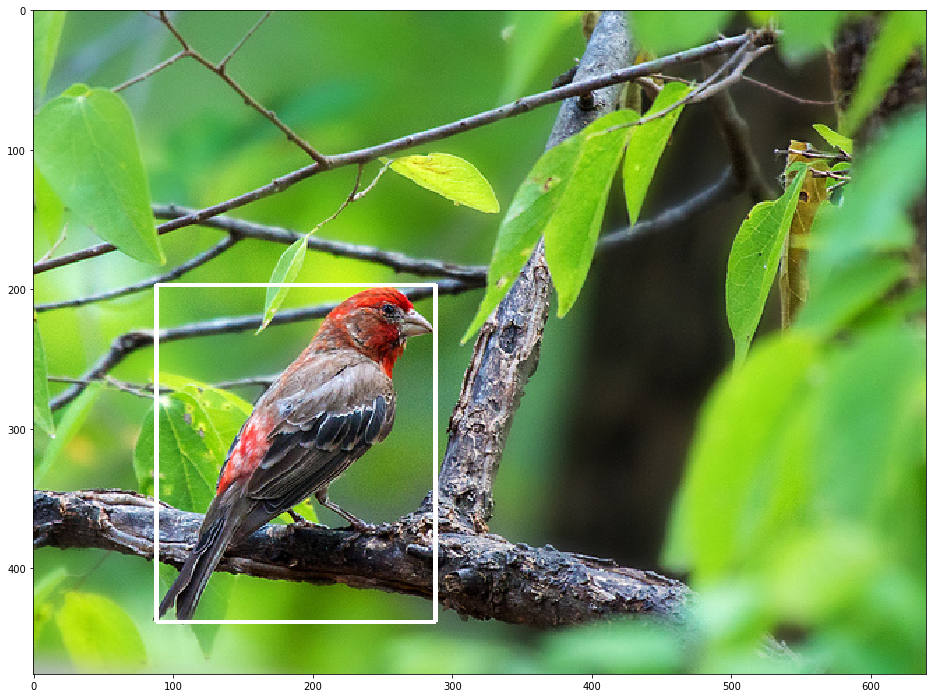

In [9]:
im = cv2.imread(os.path.join(path, df['image'][index]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16,16))
# fig, ax = plt.subplots()
for box_index in range(len(literal_eval(df['label'][index]))):
    x1 = literal_eval(df['x1'][index])[box_index]
    y1 = literal_eval(df['y1'][index])[box_index]
    x2 = literal_eval(df['x2'][index])[box_index]
    y2 = literal_eval(df['y2'][index])[box_index]
    cv2.rectangle(im, (x1, y1), (x2, y2), (255, 255, 255), 2)
    
plt.imshow(im)
# df.loc[index]

### Create tfrecord writer

In [10]:
from fastestimator.op import NumpyOp
from fastestimator.op.numpyop import ImageReader, Resize
from fastestimator.util import RecordWriter

In [11]:
class String2List(NumpyOp):
    # this thing converts '[1, 2, 3]' into np.array([1, 2, 3])
    def forward(self, data, state):
        data = map(literal_eval, data)
        return data

In [12]:
class GenerateTarget(NumpyOp):
    def __init__(self, inputs=None, outputs=None, mode=None, input_shape=(800, 800, 3)):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.pyramid_levels = [3, 4, 5, 6, 7]
        self.sizes = [32, 64, 128, 256, 512]
        self.strides = [8, 16, 32, 64, 128]
        self.ratios = np.array([0.5, 1, 2], dtype=np.float)
        self.scales = np.array([2**0, 2**(1.0 / 3.0), 2**(2.0 / 3.0)], dtype=np.float)

        self.anchors_list = np.zeros((0, 4))
        image_shapes = [(np.array(input_shape[:2]) + 2**pyra_level - 1) // (2**pyra_level)
                        for pyra_level in self.pyramid_levels]
        for idx, pyra_level in enumerate(self.pyramid_levels):
            base_size = self.sizes[idx]
            ratios = self.ratios
            scales = self.scales
            image_shape = image_shapes[idx]
            strides = self.strides[idx]
            anchors = self.generate_anchors_core(base_size, ratios, scales)
            shifted_anchors = self.shift(image_shape, strides, anchors)
            self.anchors_list = np.append(self.anchors_list, shifted_anchors, axis=0)

    def forward(self, data, state):
        label, x1, y1, x2, y2, image = data
        target_cls, target_loc = self.get_target(self.anchors_list, label, x1, y1, x2, y2, num_classes= num_classes) # 10 classes + bg
        return target_cls, target_loc, self.anchors_list

    def get_target(self, anchorbox, label, x1, y1, x2, y2, num_classes= num_classes):  # this is 80 not 81
        bg_index = num_classes - 1
        query_box = np.zeros((0, 4))
        query_label = np.zeros((0))
        for _x1, _y1, _x2, _y2, _label in zip(x1, y1, x2, y2, label):
            query_box = np.append(query_box, np.array([[_x1, _y1, _x2, _y2]]), axis=0)
            query_label = np.append(query_label, _label)

        overlap = compute_overlap(anchorbox.astype(np.float64), query_box.astype(np.float64))
        
        gt_argmax_overlaps_inds = np.argmax(overlap, axis=0)
        gt_max_overlaps = np.max(overlap, axis=0)
        for i,(elem_gt_argmax_overlap_ind, elem_gt_max_overlap) in enumerate(zip(gt_argmax_overlaps_inds, gt_max_overlaps)):
            overlap[elem_gt_argmax_overlap_ind, i]=1.0
            
        
        argmax_overlaps_inds = np.argmax(overlap, axis=1)
        max_overlaps = overlap[np.arange(overlap.shape[0]), argmax_overlaps_inds]
        positive_index = (max_overlaps > 0.5)
        ignore_index = (max_overlaps > 0.4) & ~positive_index
        negative_index = (max_overlaps <= 0.4)

        target_loc = get_loc_offset(query_box[argmax_overlaps_inds, :], anchorbox)
        target_cls = query_label[argmax_overlaps_inds]
        target_cls[negative_index] = bg_index
        target_cls[ignore_index] = -2  # ignore this example

        return target_cls, target_loc

    def generate_anchors_core(self, base_size, ratios, scales):
        num_anchors = len(ratios) * len(scales)
        # initialize output anchors
        anchors = np.zeros((num_anchors, 4))
        # scale base_size
        anchors[:, 2:] = base_size * np.tile(scales, (2, len(ratios))).T

        # compute areas of anchors
        areas = anchors[:, 2] * anchors[:, 3]

        # correct for ratios
        anchors[:, 2] = np.sqrt(areas / np.repeat(ratios, len(scales)))
        anchors[:, 3] = anchors[:, 2] * np.repeat(ratios, len(scales))

        # transform from (x_ctr, y_ctr, w, h) -> (x1, y1, x2, y2)
        anchors[:, 0::2] -= np.tile(anchors[:, 2] * 0.5, (2, 1)).T
        anchors[:, 1::2] -= np.tile(anchors[:, 3] * 0.5, (2, 1)).T

        return anchors

    def shift(self, image_shape, stride, anchors):
        shift_x = (np.arange(0, image_shape[1]) + 0.5) * stride
        shift_y = (np.arange(0, image_shape[0]) + 0.5) * stride
        shift_x, shift_y = np.meshgrid(shift_x, shift_y)

        shifts = np.vstack((shift_x.ravel(), shift_y.ravel(), shift_x.ravel(), shift_y.ravel())).transpose()

        A = anchors.shape[0]
        K = shifts.shape[0]
        all_anchors = (anchors.reshape((1, A, 4)) + shifts.reshape((1, K, 4)).transpose((1, 0, 2)))
        all_anchors = all_anchors.reshape((K * A, 4))

        return all_anchors

In [13]:
class ResizeCocoStyle(Resize):
    def __init__(self, target_size, keep_ratio=False, inputs=None, outputs=None, mode=None):
        super().__init__(target_size, keep_ratio=keep_ratio, inputs=inputs, outputs=outputs, mode=mode)

    def forward(self, data, state):
        img, x1, y1, x2, y2 = data
        pad  = None
        if self.keep_ratio:
            original_ratio = img.shape[1] / img.shape[0]
            target_ratio = self.target_size[1] / self.target_size[0]
            if original_ratio >= target_ratio:
                pad = (img.shape[1] / target_ratio - img.shape[0]) / 2
                pad_boarder = (np.ceil(pad).astype(np.int), np.floor(pad).astype(np.int), 0, 0)
                y1 += np.ceil(pad).astype(np.int)
                y2 += np.ceil(pad).astype(np.int)
            else:
                pad = (img.shape[0] * target_ratio - img.shape[1]) / 2
                pad_boarder = (0, 0, np.ceil(pad).astype(np.int), np.floor(pad).astype(np.int))
                x1 += np.ceil(pad).astype(np.int)
                x2 += np.ceil(pad).astype(np.int)

            img = cv2.copyMakeBorder(img, *pad_boarder, cv2.BORDER_CONSTANT)
            padimg_targimg_ratio = np.array([ img.shape[1]/self.target_size[1],
                                            img.shape[0]/self.target_size[0],
                                            img.shape[1]/self.target_size[1],
                                            img.shape[0]/self.target_size[0]], dtype=np.float)
           
        padding = np.array([pad_boarder[2], pad_boarder[0] ,pad_boarder[2], pad_boarder[0]])
        img_resize = cv2.resize(img, (self.target_size[1], self.target_size[0]), self.resize_method)
        x1 = (np.array(x1) * self.target_size[1] / img.shape[1]).astype(np.int64)
        x2 = (np.array(x2) * self.target_size[1] / img.shape[1]).astype(np.int64)
        y1 = (np.array(y1) * self.target_size[0] / img.shape[0]).astype(np.int64)
        y2 = (np.array(y2) * self.target_size[0] / img.shape[0]).astype(np.int64)
        return img_resize, x1, y1, x2, y2, padding, padimg_targimg_ratio

### Util functions

In [14]:
def get_loc_offset(box_gt, box_anchor):
    mean = 0
    std = 0.2
    anchor_width_height = np.tile(box_anchor[:, 2:] - box_anchor[:, :2], [1, 2])
    delta = (box_gt - box_anchor) / anchor_width_height
    return (delta -mean) / std

### Record writer

In [15]:
writer = RecordWriter(
    train_data=os.path.join(path, 'train_new.csv'),
    validation_data=os.path.join(path, 'val_new.csv'),
    save_dir=os.path.join(path, 'tfrecords'),
    ops=[
        ImageReader(inputs='image', outputs='image', parent_path=path),
        String2List(inputs=["label", "x1", "y1", "x2", "y2"], outputs=["label", "x1", "y1", "x2", "y2"]),
        ResizeCocoStyle((HEIGHT, WIDTH),
                        keep_ratio=True,
                        inputs=["image", "x1", "y1", "x2", "y2"],
                        outputs=["image", "x1", "y1", "x2", "y2", "padding", "padimg_targimg_ratio"]),
        ResPreprocess(inputs="image", outputs="image"),
        GenerateTarget(inputs=["label", "x1", "y1", "x2", "y2", "image"],
                       outputs=["target_cls", "target_loc", "base_loc"],
                       input_shape=(HEIGHT, WIDTH, 3))
    ])

### Pipeline

In [16]:
pipeline = fe.Pipeline(data=writer, batch_size=8, padded_batch=True, read_feature=["image", "image_id", "target_cls", "target_loc","base_loc",
                                                                                   "padding","padimg_targimg_ratio"])
# pipeline = fe.Pipeline(data=writer, batch_size=8, padded_batch=True, read_feature=["image", "image_id","x1","x2","y1","y2","orig_img_shape",
#                                                                                    "pad_img_shape","padding","padded_target_ratio"])

In [19]:
# !rm -rf /home/ubuntu/coco/tfrecords/

In [20]:
batch_data = pipeline.show_results(mode='train', num_steps=5)

FastEstimator: Saving tfrecord to /home/ubuntu/coco/tfrecords
FastEstimator: Converting Train TFRecords 0.0%, Speed: 0.00 record/sec
FastEstimator: Converting Train TFRecords 5.0%, Speed: 119.54 record/sec
FastEstimator: Converting Train TFRecords 10.0%, Speed: 108.17 record/sec
FastEstimator: Converting Train TFRecords 14.9%, Speed: 87.73 record/sec
FastEstimator: Converting Train TFRecords 19.9%, Speed: 110.82 record/sec
FastEstimator: Converting Train TFRecords 24.9%, Speed: 17.79 record/sec
FastEstimator: Converting Train TFRecords 29.9%, Speed: 20.73 record/sec
FastEstimator: Converting Train TFRecords 34.9%, Speed: 21.84 record/sec
FastEstimator: Converting Train TFRecords 39.8%, Speed: 21.86 record/sec
FastEstimator: Converting Train TFRecords 44.8%, Speed: 21.76 record/sec
FastEstimator: Converting Train TFRecords 49.8%, Speed: 21.89 record/sec
FastEstimator: Converting Train TFRecords 54.8%, Speed: 22.48 record/sec
FastEstimator: Converting Train TFRecords 59.8%, Speed: 22.25 

In [21]:
batch_data[0].keys()

dict_keys(['image', 'image_id', 'target_cls', 'target_loc', 'base_loc', 'padding', 'padimg_targimg_ratio'])

In [22]:
# idx = np.random.randint(0,5)
# # idx =4
# print('idx:',idx)
# batch_index = np.random.randint(0,8)
# print('batch_index:',batch_index)
# # batch_index = 1
# im = batch_data[idx]['image'].numpy()[batch_index]
# shape_o = batch_data[idx]['orig_img_shape'].numpy()[batch_index]
# shape_p = batch_data[idx]['pad_img_shape'].numpy()[batch_index]
# pad = batch_data[idx]['padding'].numpy()[batch_index]
# pad_targ_ratio = batch_data[idx]['padded_target_ratio'].numpy()[batch_index]
# X1 = batch_data[idx]["x1"].numpy()[batch_index]
# Y1 = batch_data[idx]["y1"].numpy()[batch_index]
# X2 = batch_data[idx]["x2"].numpy()[batch_index]
# Y2 = batch_data[idx]["y2"].numpy()[batch_index]

# bb = np.stack([X1,Y1,X2,Y2], axis=1)
# print(bb.shape)
# print(im.shape)
# im2 = cv2.resize(im,(shape_p[1], shape_p[0]))
# print(shape_o, shape_p, im2.shape)
# print(pad)
# crp_img2 = im2[pad[1]:shape_o[0]+pad[1],pad[0]:shape_o[1]+pad[0]]

# fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(16,16))
# for bb_elem in bb :
#     x1,y1,x2,y2 = bb_elem
#     im = cv2.rectangle(im, (x1, y1), (x2, y2), (255, 255, 255), 3)
#     print(pad_targ_ratio)
#     bb_elem_o = bb_elem*pad_targ_ratio - pad
#     x1,y1,x2,y2 = bb_elem_o
#     x1,y1,x2,y2 = int(x1), int(y1), int(x2), int(y2)
#     crp_img2 = cv2.rectangle(crp_img2, (x1, y1), (x2, y2), (255, 255, 255), 3)
# ax[0].imshow(im)
# ax[1].imshow(crp_img2)

### Keras definitions

#### Classification head

In [23]:
from tensorflow.python.keras import regularizers

In [30]:
def classification_sub_net(num_classes, num_anchor=9):
    model = models.Sequential()
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(
        layers.Conv2D(num_classes * num_anchor,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='sigmoid',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer=tf.initializers.constant(np.log(1 / 99)),
                      kernel_regularizer=regularizers.l2(0.0001)))
    model.add(layers.Reshape((-1, num_classes)))  # the output dimension is [batch, #anchor, #classes]
    return model

### Regression head

In [31]:
def regression_sub_net(num_anchor=9):
    model = models.Sequential()
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(
        layers.Conv2D(4 * num_anchor,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(layers.Reshape((-1, 4)))  # the output dimension is [batch, #anchor, 4]
    return model


## Define RetinaNet


In [ ]:
def RetinaNet(input_shape, num_classes, num_anchor=9):
    inputs = tf.keras.Input(shape=input_shape)
    # FPN
    #     weights = '/home/ubuntu/ResNet-50-model.keras.h5'
    resnet50 = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=inputs, pooling=None)
    #     resnet50.load_weights(weights, by_name=True)
    assert resnet50.layers[80].name == "conv3_block4_out"
    C3 = resnet50.layers[80].output
    assert resnet50.layers[142].name == "conv4_block6_out"
    C4 = resnet50.layers[142].output
    assert resnet50.layers[-1].name == "conv5_block3_out"
    C5 = resnet50.layers[-1].output
    
    P5 = layers.Conv2D(256, kernel_size=1, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.0001))(C5)
    P5_upsampling = layers.UpSampling2D()(P5)
    P4 = layers.Conv2D(256, kernel_size=1, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.0001))(C4)
    P4 = layers.Add()([P5_upsampling, P4])
    P4_upsampling = layers.UpSampling2D()(P4)
    P3 = layers.Conv2D(256, kernel_size=1, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.0001))(C3)
    
    P3 = layers.Add()([P4_upsampling, P3])
    
    P6 = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', name="P6",kernel_regularizer=regularizers.l2(0.0001))(C5)
    P7 = layers.Activation('relu')(P6)
    P7 = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', name="P7", kernel_regularizer=regularizers.l2(0.0001))(P7)
    P5 = layers.Conv2D(256, kernel_size=3, strides=1, padding='same', name="P5",kernel_regularizer=regularizers.l2(0.0001))(P5)
    P4 = layers.Conv2D(256, kernel_size=3, strides=1, padding='same', name="P4", kernel_regularizer=regularizers.l2(0.0001))(P4)
    P3 = layers.Conv2D(256, kernel_size=3, strides=1, padding='same', name="P3", kernel_regularizer=regularizers.l2(0.0001))(P3)
    # classification subnet
    cls_subnet = classification_sub_net(num_classes=num_classes, num_anchor=num_anchor)
    P3_cls = cls_subnet(P3)
    P4_cls = cls_subnet(P4)
    P5_cls = cls_subnet(P5)
    P6_cls = cls_subnet(P6)
    P7_cls = cls_subnet(P7)
    cls_output = layers.Concatenate(axis=-2)([P3_cls, P4_cls, P5_cls, P6_cls, P7_cls])
    # localization subnet
    loc_subnet = regression_sub_net(num_anchor=num_anchor)
    P3_loc = loc_subnet(P3)
    P4_loc = loc_subnet(P4)
    P5_loc = loc_subnet(P5)
    P6_loc = loc_subnet(P6)
    P7_loc = loc_subnet(P7)
    loc_output = layers.Concatenate(axis=-2)([P3_loc, P4_loc, P5_loc, P6_loc, P7_loc])
    return tf.keras.Model(inputs=inputs, outputs=[cls_output, loc_output])

## Define loss

In [33]:
from fastestimator.op.tensorop import Loss

In [34]:
class RetinaLoss(Loss):
    def focal_loss(self, cls_gt_example, cls_pred_example, num_classes, alpha=0.25, gamma=2.0):
        bg_index = num_classes - 1
        # cls_gt has shape [A], cls_pred is in [A, K]
        # gather the objects and background, discard the rest
        obj_idx = tf.where(tf.logical_and(tf.greater_equal(cls_gt_example, 0), tf.less(cls_gt_example, bg_index)))
        obj_bg_idx = tf.where(tf.greater_equal(cls_gt_example, 0))
        obj_bg_count = tf.cast(tf.shape(obj_bg_idx)[0], tf.float32)
        obj_count = tf.cast(tf.maximum(tf.shape(obj_idx)[0], 1), tf.float32)
        cls_gt_example = tf.one_hot(cls_gt_example, num_classes)
        cls_gt_example = tf.gather_nd(cls_gt_example, obj_bg_idx)
        cls_pred_example = tf.gather_nd(cls_pred_example, obj_bg_idx)
        cls_gt_example = tf.reshape(cls_gt_example, (-1, 1))
        cls_pred_example = tf.reshape(cls_pred_example, (-1, 1))
        # compute the focal weight on each selected anchor box
        alpha_factor = tf.ones_like(cls_gt_example) * alpha
        alpha_factor = tf.where(tf.equal(cls_gt_example, 1), alpha_factor, 1 - alpha_factor)
        focal_weight = tf.where(tf.equal(cls_gt_example, 1), 1 - cls_pred_example, cls_pred_example)
        focal_weight = alpha_factor * focal_weight**gamma / obj_count
        cls_loss = tf.losses.BinaryCrossentropy(reduction='sum')(cls_gt_example,
                                                                 cls_pred_example,
                                                                 sample_weight=focal_weight)
        return cls_loss

    def smooth_l1(self, loc_gt_example, loc_pred_example, cls_gt_example, cls_pred_example, num_classes):
        # loc_gt anf loc_pred has shape [A, 4]
        bg_index = num_classes - 1
        obj_idx = tf.where(tf.logical_and(tf.greater_equal(cls_gt_example, 0), tf.less(cls_gt_example, bg_index)))
        sigma = 3
        sigma_squared = sigma**3
        obj_count = tf.cast(tf.maximum(tf.shape(obj_idx)[0], 1), tf.float32)
        loc_gt = tf.gather_nd(loc_gt_example, obj_idx)
        loc_pred = tf.gather_nd(loc_pred_example, obj_idx)
        loc_gt = tf.reshape(loc_gt, (-1, 1))
        loc_pred = tf.reshape(loc_pred, (-1, 1))
        loc_diff = tf.abs(loc_gt - loc_pred)
        smooth_l1_loss = tf.where(tf.less(loc_diff, 1 / sigma_squared),
                                  0.5 * loc_diff**2 * sigma_squared,
                                  loc_diff - 0.5 / sigma_squared)
        smooth_l1_loss = tf.reduce_sum(smooth_l1_loss) / obj_count
        return smooth_l1_loss

    def forward(self, data, state):
        cls_gt, loc_gt, cls_pred, loc_pred = data
        cls_gt = tf.cast(cls_gt, tf.int32)
        batch_size = state["local_batch_size"]
        focal_loss = tf.map_fn(lambda x: self.focal_loss(x[0], x[1], num_classes= num_classes), 
                                        (cls_gt, cls_pred),dtype=tf.float32, back_prop=False)
        smooth_l1_loss = tf.map_fn(lambda x: self.smooth_l1(x[0], x[1], x[2], x[3], num_classes= num_classes),(loc_gt, loc_pred, cls_gt, cls_pred),
                                   dtype=tf.float32, back_prop=False)
        total_loss = tf.add(focal_loss, smooth_l1_loss)
        return total_loss, focal_loss, smooth_l1_loss
    


In [35]:
# Not using PredictBox yet

class PredictBox(TensorOp):
    def __init__(self, num_classes, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.num_classes = num_classes
        self.bg_index = num_classes - 1

    def forward(self, data, state):
        cls_pred, loc_pred, loc_base = data
        input_width = WIDTH
        input_height = HEIGHT
        top_n = 300
        score_threshold = 0.05
        std = 0.2
        mean = 0
        # convert the residual prediction to absolute prediction in (x1, y1, x2, y2)
        anchor_w_h = tf.tile(loc_base[:, :, 2:], [1, 1, 2]) - tf.tile(loc_base[:, :, :2], [1, 1, 2])
        anchorbox = loc_base
        loc_pred_abs = tf.map_fn(lambda x: (x[0] * std + mean) * x[1] + x[2],
                                 elems=(loc_pred, anchor_w_h, anchorbox),
                                 dtype=tf.float32,
                                 back_prop=False)
        x1 = tf.clip_by_value(loc_pred_abs[:, :, 0], 0, input_width)
        y1 = tf.clip_by_value(loc_pred_abs[:, :, 1], 0, input_height)
        x2 = tf.clip_by_value(loc_pred_abs[:, :, 2], 0, input_width)
        y2 = tf.clip_by_value(loc_pred_abs[:, :, 3], 0, input_height)
        loc_pred_abs = tf.stack([x1, y1, x2, y2], axis=2)

        num_batch, num_anchor, _ = loc_pred_abs.shape
        cls_best_score = tf.reduce_max(cls_pred, axis=-1)
        cls_best_class = tf.argmax(cls_pred, axis=-1)

        cls_best_score = tf.where(tf.not_equal(cls_best_class, self.bg_index), cls_best_score, 0)

        # select top n anchor boxes to proceed
        # Padded Nonmax suppression with threshold
        selected_indices_padded = tf.map_fn(
            lambda x: tf.image.non_max_suppression_padded(
                x[0], x[1], top_n, pad_to_max_output_size=True, score_threshold=score_threshold).selected_indices,
            (loc_pred_abs, cls_best_score),
            dtype=tf.int32,
            back_prop=False)
        valid_outputs = tf.map_fn(
            lambda x: tf.image.non_max_suppression_padded(
                x[0], x[1], top_n, pad_to_max_output_size=True, score_threshold=score_threshold).valid_outputs,
            (loc_pred_abs, cls_best_score),
            dtype=tf.int32,
            back_prop=False)
        
        return loc_pred_abs, selected_indices_padded, valid_outputs

## Create network

In [36]:
from fastestimator.op.tensorop.model import ModelOp

# prepare model
model = fe.build(model_def=lambda: RetinaNet(input_shape=(HEIGHT, WIDTH, 3), num_classes= num_classes),
                 model_name="retinanet",
                 optimizer=tf.optimizers.Adam(learning_rate=0.00001),
                 loss_name="loss")

network = fe.Network(ops=[
    ModelOp(inputs="image", model=model, outputs=["pred_cls", "pred_loc"]),
    PredictBox(num_classes, inputs=["pred_cls","pred_loc","base_loc"], outputs=("abs_loc","selected_indices_padded", "valid_outputs"), mode="eval"),
    RetinaLoss(inputs=["target_cls", "target_loc", "pred_cls", "pred_loc"], outputs=["loss","focal","smooth"]),
])


### Create estimator

In [37]:
6000/32

187.5

In [38]:
from fastestimator.trace.adapt.lr_controller import LRController
from fastestimator.trace.metric.coco_mean_avg_precision import MeanAveragePrecision

# prepare estimator
model_dir = '/home/ubuntu/coco/bestmodel'
traces = [
    MeanAveragePrecision('selected_indices_padded','valid_outputs','image_id','pred_cls', 'abs_loc',
                         'padimg_targimg_ratio', 'padding', coco_path='/home/ubuntu/coco', val_csv='val_new.csv'),
    LRController(model_name="retinanet", reduce_on_eval=True, reduce_patience=18, reduce_factor=0.5, min_lr=1e-08),
    ModelSaver(model_name="retinanet", save_dir=model_dir, save_best=True)
]
estimator = fe.Estimator(network=network,
                         pipeline=pipeline,
                         epochs=300,
                         steps_per_epoch=85,
                         log_steps=5,
                         traces=traces)

loading annotations into memory...
Done (t=5.67s)
creating index...
index created!


In [ ]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator: Reading non-empty directory: /home/ubuntu/coco/tfrecords
FastEstimator: Found 5938 examples for train in /home/ubuntu/coco/tfrecords/train_summary0.json
FastEstimator: Found 3000 examples for eval in /home/ubuntu/coco/tfrecords/eval_summary0.json
FastEstimator-Start: step: 0; total_train_steps: 25500; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 0; loss: 8848.706; focal: 8845.336; smooth: 3.3709557; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5; loss: 2932.6575; focal: 2929.6462; smooth: 3.0112495; examples/sec: 34.2; progress: 0.0

FastEstimator-Train: step: 245; loss: 15.715851; focal: 12.782486; smooth: 2.9333668; examples/sec: 18.6; progress: 1.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 250; loss: 14.765244; focal: 11.980671; smooth: 2.784573; examples/sec: 14.5; progress: 1.0%; retinanet_lr: 1e-05; 
Loading and preparing results...
No records found to evaluate
FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 255; epoch: 2; loss: 19.768742; min_loss: 19.768742; since_best_loss: 0; 
FastEstimator-Train: step: 255; loss: 19.671066; focal: 16.368; smooth: 3.303068; examples/sec: 17.6; progress: 1.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 260; loss: 16.684002; focal: 12.666977; smooth: 4.017022; examples/sec: 34.3; progress: 1.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 265; loss: 15.022303; focal: 12.122568; smooth: 2.8997335; examples/sec: 20.0; progress: 1.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 270;

FastEstimator-Train: step: 505; loss: 10.512516; focal: 7.961173; smooth: 2.5513434; examples/sec: 20.8; progress: 2.0%; retinanet_lr: 1e-05; 
Loading and preparing results...
No records found to evaluate
FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 510; epoch: 5; loss: 16.809526; min_loss: 16.809526; since_best_loss: 0; 
FastEstimator-Train: step: 510; loss: 10.005174; focal: 7.306382; smooth: 2.6987915; examples/sec: 22.9; progress: 2.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 515; loss: 11.06971; focal: 8.177433; smooth: 2.8922763; examples/sec: 29.9; progress: 2.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 520; loss: 12.718601; focal: 8.596506; smooth: 4.1220946; examples/sec: 19.7; progress: 2.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 525; loss: 8.714689; focal: 5.954387; smooth: 2.760301; examples/sec: 20.1; progress: 2.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 530; l

FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 765; epoch: 8; loss: 8.799152; min_loss: 8.799152; since_best_loss: 0; 
FastEstimator-Train: step: 765; loss: 6.445569; focal: 3.8968835; smooth: 2.5486856; examples/sec: 34.2; progress: 3.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 770; loss: 6.46506; focal: 3.7883534; smooth: 2.6767068; examples/sec: 34.5; progress: 3.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 775; loss: 7.7604294; focal: 5.0939817; smooth: 2.666448; examples/sec: 24.2; progress: 3.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 780; loss: 6.150062; focal: 3.9581006; smooth: 2.1919613; examples/sec: 21.3; progress: 3.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 785; loss: 7.5986314; focal: 4.7890134; smooth: 2.809618; examples/sec: 18.8; progress: 3.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 790; loss: 7.534381; focal: 4.074458; smooth: 3.4599218; examples/se

FastEstimator-Train: step: 1020; loss: 6.2427635; focal: 3.5031276; smooth: 2.739636; examples/sec: 23.0; progress: 4.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1025; loss: 5.0364046; focal: 2.7272732; smooth: 2.3091311; examples/sec: 33.3; progress: 4.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1030; loss: 5.182149; focal: 2.8493087; smooth: 2.3328402; examples/sec: 20.9; progress: 4.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1035; loss: 5.4385157; focal: 2.8336883; smooth: 2.6048276; examples/sec: 20.9; progress: 4.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1040; loss: 5.2209883; focal: 2.7200627; smooth: 2.500926; examples/sec: 20.0; progress: 4.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1045; loss: 5.336363; focal: 2.9058788; smooth: 2.4304843; examples/sec: 21.2; progress: 4.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1050; loss: 5.07111; focal: 2.3834834; smooth: 2.6876264; examples/sec: 20.4; progress: 4.1%; retinanet_lr:

FastEstimator-Train: step: 1280; loss: 4.455181; focal: 2.1688087; smooth: 2.2863727; examples/sec: 32.2; progress: 5.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1285; loss: 5.4646435; focal: 2.9142385; smooth: 2.550405; examples/sec: 20.4; progress: 5.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1290; loss: 5.608742; focal: 3.0480714; smooth: 2.5606709; examples/sec: 19.7; progress: 5.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1295; loss: 4.1710806; focal: 1.9194708; smooth: 2.2516098; examples/sec: 20.1; progress: 5.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1300; loss: 4.955103; focal: 2.9642918; smooth: 1.9908112; examples/sec: 20.0; progress: 5.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1305; loss: 5.1608276; focal: 2.9385731; smooth: 2.2222543; examples/sec: 19.9; progress: 5.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1310; loss: 5.1389513; focal: 2.7192702; smooth: 2.419681; examples/sec: 20.0; progress: 5.1%; retinanet_lr

FastEstimator-Train: step: 1540; loss: 4.0987864; focal: 2.0530572; smooth: 2.0457287; examples/sec: 34.1; progress: 6.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1545; loss: 4.216535; focal: 2.1514878; smooth: 2.0650475; examples/sec: 34.3; progress: 6.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1550; loss: 4.0116673; focal: 1.902599; smooth: 2.1090684; examples/sec: 32.9; progress: 6.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1555; loss: 4.8020487; focal: 2.5517223; smooth: 2.2503269; examples/sec: 31.5; progress: 6.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1560; loss: 6.057812; focal: 2.966584; smooth: 3.0912282; examples/sec: 31.6; progress: 6.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1565; loss: 4.1858664; focal: 1.9598795; smooth: 2.225987; examples/sec: 31.6; progress: 6.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1570; loss: 4.234635; focal: 2.0173588; smooth: 2.2172756; examples/sec: 34.0; progress: 6.2%; retinanet_lr:

FastEstimator-Train: step: 1800; loss: 4.816292; focal: 2.4309835; smooth: 2.385308; examples/sec: 21.0; progress: 7.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1805; loss: 4.2440352; focal: 2.0506902; smooth: 2.193345; examples/sec: 22.1; progress: 7.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1810; loss: 3.790722; focal: 1.7958395; smooth: 1.9948823; examples/sec: 20.9; progress: 7.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1815; loss: 3.9053144; focal: 1.9509174; smooth: 1.9543972; examples/sec: 21.2; progress: 7.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1820; loss: 4.163284; focal: 2.220808; smooth: 1.9424756; examples/sec: 18.3; progress: 7.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1825; loss: 4.3735914; focal: 2.1538305; smooth: 2.2197614; examples/sec: 20.3; progress: 7.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1830; loss: 4.1248503; focal: 1.9371802; smooth: 2.1876698; examples/sec: 19.2; progress: 7.2%; retinanet_lr:

FastEstimator-Train: step: 2065; loss: 4.179347; focal: 2.2415276; smooth: 1.9378195; examples/sec: 19.3; progress: 8.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2070; loss: 4.302354; focal: 2.0801191; smooth: 2.2222347; examples/sec: 20.4; progress: 8.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2075; loss: 4.3945694; focal: 2.208119; smooth: 2.1864507; examples/sec: 19.9; progress: 8.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2080; loss: 3.6996996; focal: 1.7201097; smooth: 1.9795893; examples/sec: 20.2; progress: 8.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2085; loss: 3.6156027; focal: 1.6530063; smooth: 1.9625964; examples/sec: 18.2; progress: 8.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2090; loss: 4.263736; focal: 1.9832431; smooth: 2.2804925; examples/sec: 20.7; progress: 8.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2095; loss: 4.1967134; focal: 1.9695425; smooth: 2.227171; examples/sec: 20.3; progress: 8.2%; retinanet_lr

FastEstimator-Train: step: 2325; loss: 3.484814; focal: 1.7918952; smooth: 1.6929189; examples/sec: 26.3; progress: 9.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2330; loss: 4.940482; focal: 2.3619444; smooth: 2.5785372; examples/sec: 29.1; progress: 9.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2335; loss: 4.254243; focal: 1.9289167; smooth: 2.3253257; examples/sec: 30.9; progress: 9.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2340; loss: 4.6437855; focal: 2.149426; smooth: 2.4943593; examples/sec: 27.7; progress: 9.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2345; loss: 3.679964; focal: 1.8744135; smooth: 1.8055506; examples/sec: 25.7; progress: 9.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2350; loss: 4.0142474; focal: 1.8052018; smooth: 2.2090454; examples/sec: 25.7; progress: 9.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2355; loss: 4.6064034; focal: 2.0597315; smooth: 2.5466716; examples/sec: 24.0; progress: 9.2%; retinanet_lr

FastEstimator-Train: step: 2590; loss: 3.6658368; focal: 1.7186782; smooth: 1.9471585; examples/sec: 24.3; progress: 10.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2595; loss: 3.9571257; focal: 1.8084008; smooth: 2.148725; examples/sec: 21.7; progress: 10.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2600; loss: 3.92813; focal: 1.8119159; smooth: 2.1162143; examples/sec: 21.4; progress: 10.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2605; loss: 3.2867713; focal: 1.5483947; smooth: 1.7383765; examples/sec: 21.1; progress: 10.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2610; loss: 3.7141287; focal: 1.8433115; smooth: 1.8708172; examples/sec: 21.2; progress: 10.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2615; loss: 3.799075; focal: 1.8238719; smooth: 1.9752024; examples/sec: 20.8; progress: 10.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2620; loss: 4.595332; focal: 2.5079763; smooth: 2.0873556; examples/sec: 20.7; progress: 10.3%; retin

FastEstimator-Train: step: 2850; loss: 4.8180404; focal: 2.8083239; smooth: 2.009716; examples/sec: 20.4; progress: 11.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2855; loss: 4.138815; focal: 1.883911; smooth: 2.2549043; examples/sec: 19.9; progress: 11.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2860; loss: 4.0854115; focal: 1.9214585; smooth: 2.1639528; examples/sec: 20.2; progress: 11.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2865; loss: 3.2519293; focal: 1.6368027; smooth: 1.6151267; examples/sec: 20.7; progress: 11.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2870; loss: 3.7083771; focal: 1.698662; smooth: 2.0097153; examples/sec: 20.2; progress: 11.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2875; loss: 4.122178; focal: 2.1647594; smooth: 1.9574186; examples/sec: 19.5; progress: 11.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2880; loss: 3.5955613; focal: 1.7768992; smooth: 1.8186617; examples/sec: 19.1; progress: 11.3%; retin

FastEstimator-Train: step: 3110; loss: 3.1696694; focal: 1.3656285; smooth: 1.8040409; examples/sec: 31.0; progress: 12.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3115; loss: 3.522144; focal: 1.4539237; smooth: 2.0682204; examples/sec: 30.8; progress: 12.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3120; loss: 3.4419088; focal: 1.5241156; smooth: 1.9177933; examples/sec: 30.9; progress: 12.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3125; loss: 3.4890804; focal: 1.532165; smooth: 1.9569154; examples/sec: 31.3; progress: 12.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3130; loss: 3.6726348; focal: 1.7294691; smooth: 1.9431655; examples/sec: 29.7; progress: 12.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3135; loss: 3.59566; focal: 1.8456285; smooth: 1.7500315; examples/sec: 29.2; progress: 12.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3140; loss: 3.4057631; focal: 1.6685209; smooth: 1.7372421; examples/sec: 27.2; progress: 12.3%; reti

FastEstimator-Train: step: 3370; loss: 3.2915428; focal: 1.6291149; smooth: 1.6624279; examples/sec: 19.1; progress: 13.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3375; loss: 3.770384; focal: 2.034593; smooth: 1.7357905; examples/sec: 20.6; progress: 13.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3380; loss: 3.0463216; focal: 1.395091; smooth: 1.6512306; examples/sec: 19.5; progress: 13.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3385; loss: 3.0805204; focal: 1.3295043; smooth: 1.751016; examples/sec: 20.3; progress: 13.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3390; loss: 2.946753; focal: 1.3630531; smooth: 1.5837; examples/sec: 20.4; progress: 13.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3395; loss: 3.469658; focal: 1.5736365; smooth: 1.8960217; examples/sec: 20.9; progress: 13.3%; retinanet_lr: 1e-05; 
Loading and preparing results...
No records found to evaluate
FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/r

FastEstimator-Train: step: 3630; loss: 3.190539; focal: 1.4838814; smooth: 1.7066574; examples/sec: 18.6; progress: 14.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3635; loss: 2.730093; focal: 0.98004603; smooth: 1.7500468; examples/sec: 19.5; progress: 14.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3640; loss: 4.519923; focal: 1.9019281; smooth: 2.6179948; examples/sec: 18.6; progress: 14.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3645; loss: 2.932024; focal: 1.2090161; smooth: 1.723008; examples/sec: 18.9; progress: 14.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3650; loss: 2.5949633; focal: 1.2081865; smooth: 1.3867767; examples/sec: 19.4; progress: 14.3%; retinanet_lr: 1e-05; 
Loading and preparing results...
No records found to evaluate
FastEstimator-Eval: step: 3655; epoch: 42; loss: 3.3666773; min_loss: 3.2581794; since_best_loss: 1; 
FastEstimator-Train: step: 3655; loss: 3.5984888; focal: 1.4146574; smooth: 2.1838312; examples/sec: 20.7; pro

FastEstimator-Train: step: 3890; loss: 3.6575649; focal: 2.000702; smooth: 1.656863; examples/sec: 22.0; progress: 15.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3895; loss: 3.165276; focal: 1.5721385; smooth: 1.5931373; examples/sec: 22.9; progress: 15.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3900; loss: 2.9386697; focal: 1.2194222; smooth: 1.7192476; examples/sec: 20.9; progress: 15.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3905; loss: 2.981817; focal: 1.2632368; smooth: 1.7185802; examples/sec: 21.0; progress: 15.3%; retinanet_lr: 1e-05; 
Loading and preparing results...
No records found to evaluate
FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 3910; epoch: 45; loss: 3.1042; min_loss: 3.1042; since_best_loss: 0; 
FastEstimator-Train: step: 3910; loss: 3.0674047; focal: 1.1641679; smooth: 1.9032369; examples/sec: 21.0; progress: 15.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: st

FastEstimator-Train: step: 4150; loss: 3.0302124; focal: 1.1512942; smooth: 1.878918; examples/sec: 20.2; progress: 16.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4155; loss: 2.9881387; focal: 1.1489509; smooth: 1.8391879; examples/sec: 20.7; progress: 16.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4160; loss: 2.3211155; focal: 0.940882; smooth: 1.3802333; examples/sec: 20.1; progress: 16.3%; retinanet_lr: 1e-05; 
Loading and preparing results...
No records found to evaluate
FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 4165; epoch: 48; loss: 2.9547207; min_loss: 2.9547207; since_best_loss: 0; 
FastEstimator-Train: step: 4165; loss: 2.9282472; focal: 1.2759302; smooth: 1.652317; examples/sec: 21.4; progress: 16.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4170; loss: 2.5205214; focal: 1.001616; smooth: 1.5189056; examples/sec: 32.1; progress: 16.4%; retinanet_lr: 1e-05; 
FastEstimator-Tra

FastEstimator-Train: step: 4410; loss: 2.654849; focal: 1.1208566; smooth: 1.5339923; examples/sec: 20.3; progress: 17.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4415; loss: 2.8692358; focal: 1.2818909; smooth: 1.5873449; examples/sec: 23.2; progress: 17.3%; retinanet_lr: 1e-05; 
Loading and preparing results...
No records found to evaluate
FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 4420; epoch: 51; loss: 2.8643372; min_loss: 2.8643372; since_best_loss: 0; 
FastEstimator-Train: step: 4420; loss: 3.0263476; focal: 1.3393584; smooth: 1.6869891; examples/sec: 34.4; progress: 17.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4425; loss: 2.8758125; focal: 1.3164679; smooth: 1.5593448; examples/sec: 34.7; progress: 17.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4430; loss: 3.5670724; focal: 1.716338; smooth: 1.8507346; examples/sec: 34.7; progress: 17.4%; retinanet_lr: 1e-05; 
FastEstimator-T

FastEstimator-Train: step: 4670; loss: 2.7456102; focal: 1.0613065; smooth: 1.6843035; examples/sec: 24.9; progress: 18.3%; retinanet_lr: 1e-05; 
Loading and preparing results...
No records found to evaluate
FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 4675; epoch: 54; loss: 2.8207712; min_loss: 2.8207712; since_best_loss: 0; 
FastEstimator-Train: step: 4675; loss: 2.9428413; focal: 1.2615606; smooth: 1.6812809; examples/sec: 24.6; progress: 18.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4680; loss: 2.6333027; focal: 1.1239054; smooth: 1.5093973; examples/sec: 34.3; progress: 18.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4685; loss: 2.2252378; focal: 0.9443487; smooth: 1.280889; examples/sec: 28.2; progress: 18.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4690; loss: 2.654158; focal: 1.0481968; smooth: 1.6059613; examples/sec: 26.7; progress: 18.4%; retinanet_lr: 1e-05; 
FastEstimator-T

FastEstimator-Train: step: 4925; loss: 2.3790445; focal: 1.0232016; smooth: 1.3558431; examples/sec: 20.6; progress: 19.3%; retinanet_lr: 1e-05; 
Loading and preparing results...
No records found to evaluate
FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 4930; epoch: 57; loss: 2.7383606; min_loss: 2.7383606; since_best_loss: 0; 
FastEstimator-Train: step: 4930; loss: 2.4359398; focal: 0.8521843; smooth: 1.5837555; examples/sec: 21.9; progress: 19.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4935; loss: 2.6523094; focal: 1.298772; smooth: 1.3535376; examples/sec: 33.4; progress: 19.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4940; loss: 3.0089433; focal: 1.2968225; smooth: 1.7121208; examples/sec: 21.0; progress: 19.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4945; loss: 3.660872; focal: 1.8556738; smooth: 1.8051983; examples/sec: 20.5; progress: 19.4%; retinanet_lr: 1e-05; 
FastEstimator-T

Loading and preparing results...
No records found to evaluate
FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 5185; epoch: 60; loss: 2.6669993; min_loss: 2.6669993; since_best_loss: 0; 
FastEstimator-Train: step: 5185; loss: 3.1508865; focal: 1.3145177; smooth: 1.8363686; examples/sec: 34.6; progress: 20.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5190; loss: 2.6267703; focal: 1.0862899; smooth: 1.5404804; examples/sec: 34.2; progress: 20.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5195; loss: 3.0203638; focal: 1.2554556; smooth: 1.7649082; examples/sec: 3.3; progress: 20.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5200; loss: 2.5327349; focal: 1.1341058; smooth: 1.3986292; examples/sec: 31.2; progress: 20.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5205; loss: 2.7239819; focal: 1.1256548; smooth: 1.598327; examples/sec: 28.6; progress: 20.4%; retinanet_lr: 1e-05; 
FastEstimator-T

Loading and preparing results...
No records found to evaluate
FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 5440; epoch: 63; loss: 2.6034226; min_loss: 2.6034226; since_best_loss: 0; 
FastEstimator-Train: step: 5440; loss: 2.928679; focal: 1.2341876; smooth: 1.6944914; examples/sec: 24.3; progress: 21.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5445; loss: 2.8683195; focal: 1.3544917; smooth: 1.5138279; examples/sec: 33.9; progress: 21.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5450; loss: 3.5426965; focal: 1.8868937; smooth: 1.6558027; examples/sec: 24.6; progress: 21.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5455; loss: 2.0315824; focal: 0.89587337; smooth: 1.1357089; examples/sec: 28.5; progress: 21.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5460; loss: 2.918189; focal: 1.1782042; smooth: 1.739985; examples/sec: 34.2; progress: 21.4%; retinanet_lr: 1e-05; 
FastEstimator-T

FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 5695; epoch: 66; loss: 2.525806; min_loss: 2.525806; since_best_loss: 0; 
FastEstimator-Train: step: 5695; loss: 2.8389049; focal: 1.2901566; smooth: 1.5487483; examples/sec: 20.7; progress: 22.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5700; loss: 3.146145; focal: 1.2822499; smooth: 1.8638954; examples/sec: 32.6; progress: 22.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5705; loss: 2.5691762; focal: 1.0879939; smooth: 1.4811826; examples/sec: 19.7; progress: 22.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5710; loss: 2.3410282; focal: 1.001738; smooth: 1.3392901; examples/sec: 18.7; progress: 22.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5715; loss: 2.4323978; focal: 1.118843; smooth: 1.3135546; examples/sec: 20.3; progress: 22.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5720; loss: 2.8102436; focal: 1.1605732; smooth: 1.64

FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 5950; epoch: 69; loss: 2.4394672; min_loss: 2.4394672; since_best_loss: 0; 
FastEstimator-Train: step: 5950; loss: 2.8898997; focal: 1.1185443; smooth: 1.7713552; examples/sec: 30.1; progress: 23.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5955; loss: 2.3953352; focal: 0.92232203; smooth: 1.4730132; examples/sec: 34.0; progress: 23.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5960; loss: 2.7677095; focal: 1.1309597; smooth: 1.6367497; examples/sec: 34.4; progress: 23.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5965; loss: 2.3023791; focal: 0.9158276; smooth: 1.3865514; examples/sec: 27.1; progress: 23.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5970; loss: 2.3323998; focal: 0.94888395; smooth: 1.3835158; examples/sec: 26.5; progress: 23.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5975; loss: 2.3511329; focal: 0.8767466; smoot

FastEstimator-Train: step: 6205; loss: 2.614051; focal: 1.0818416; smooth: 1.5322096; examples/sec: 21.7; progress: 24.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6210; loss: 2.1863637; focal: 0.8688292; smooth: 1.3175347; examples/sec: 34.4; progress: 24.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6215; loss: 3.4208984; focal: 1.3661238; smooth: 2.0547745; examples/sec: 22.7; progress: 24.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6220; loss: 2.9510016; focal: 1.1498785; smooth: 1.801123; examples/sec: 19.6; progress: 24.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6225; loss: 2.4490612; focal: 1.2565753; smooth: 1.1924858; examples/sec: 19.2; progress: 24.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6230; loss: 2.4360058; focal: 1.0287924; smooth: 1.4072137; examples/sec: 20.7; progress: 24.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6235; loss: 2.2914066; focal: 0.8927096; smooth: 1.3986971; examples/sec: 22.1; progress: 24.5%; re

FastEstimator-Train: step: 6460; loss: 2.1916485; focal: 1.0321577; smooth: 1.1594908; examples/sec: 21.7; progress: 25.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6465; loss: 2.5446382; focal: 1.1038373; smooth: 1.4408008; examples/sec: 32.1; progress: 25.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6470; loss: 2.8713036; focal: 1.1862073; smooth: 1.6850961; examples/sec: 19.3; progress: 25.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6475; loss: 1.9951056; focal: 0.7655339; smooth: 1.2295716; examples/sec: 18.6; progress: 25.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6480; loss: 2.2775197; focal: 0.88726896; smooth: 1.3902507; examples/sec: 19.4; progress: 25.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6485; loss: 2.3072379; focal: 0.897854; smooth: 1.409384; examples/sec: 19.1; progress: 25.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6490; loss: 2.2279973; focal: 0.75820434; smooth: 1.469793; examples/sec: 19.4; progress: 25.5%; r

FastEstimator-Train: step: 6720; loss: 1.9338866; focal: 0.86267984; smooth: 1.0712066; examples/sec: 34.5; progress: 26.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6725; loss: 3.6171453; focal: 1.4103738; smooth: 2.2067716; examples/sec: 23.4; progress: 26.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6730; loss: 2.0490284; focal: 0.7697578; smooth: 1.2792706; examples/sec: 33.0; progress: 26.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6735; loss: 1.8487378; focal: 0.71378815; smooth: 1.1349497; examples/sec: 33.8; progress: 26.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6740; loss: 2.071536; focal: 0.7853981; smooth: 1.2861379; examples/sec: 33.9; progress: 26.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6745; loss: 2.360835; focal: 0.94795686; smooth: 1.4128785; examples/sec: 33.7; progress: 26.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6750; loss: 3.3314989; focal: 1.2989461; smooth: 2.0325527; examples/sec: 34.2; progress: 26.5%;

FastEstimator-Train: step: 6980; loss: 2.3149781; focal: 0.89537996; smooth: 1.4195981; examples/sec: 21.0; progress: 27.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6985; loss: 2.4945962; focal: 1.222425; smooth: 1.2721713; examples/sec: 21.9; progress: 27.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6990; loss: 2.466271; focal: 0.9727864; smooth: 1.4934846; examples/sec: 21.4; progress: 27.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6995; loss: 2.23958; focal: 0.8986095; smooth: 1.3409705; examples/sec: 21.1; progress: 27.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7000; loss: 2.3717644; focal: 1.0300888; smooth: 1.3416756; examples/sec: 20.3; progress: 27.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7005; loss: 2.5330143; focal: 1.0732147; smooth: 1.4597995; examples/sec: 21.3; progress: 27.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7010; loss: 2.3493943; focal: 1.0542855; smooth: 1.2951087; examples/sec: 25.2; progress: 27.5%; ret

FastEstimator-Train: step: 7240; loss: 1.9825094; focal: 0.8087112; smooth: 1.1737984; examples/sec: 19.9; progress: 28.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7245; loss: 1.9452595; focal: 0.76384187; smooth: 1.1814175; examples/sec: 19.4; progress: 28.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7250; loss: 2.0995798; focal: 0.7894068; smooth: 1.310173; examples/sec: 19.3; progress: 28.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7255; loss: 1.8728138; focal: 0.71653605; smooth: 1.1562778; examples/sec: 18.8; progress: 28.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7260; loss: 2.0447412; focal: 0.84396464; smooth: 1.2007766; examples/sec: 18.7; progress: 28.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7265; loss: 2.4867053; focal: 0.90892553; smooth: 1.5777798; examples/sec: 19.6; progress: 28.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7270; loss: 1.9545856; focal: 0.71156895; smooth: 1.2430168; examples/sec: 19.5; progress: 28.

FastEstimator-Train: step: 7505; loss: 2.2479596; focal: 0.94472456; smooth: 1.3032348; examples/sec: 26.7; progress: 29.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7510; loss: 1.9085763; focal: 0.7300753; smooth: 1.1785009; examples/sec: 24.1; progress: 29.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7515; loss: 2.2378335; focal: 0.8806181; smooth: 1.3572152; examples/sec: 26.7; progress: 29.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7520; loss: 2.8091054; focal: 1.2618294; smooth: 1.547276; examples/sec: 24.0; progress: 29.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7525; loss: 2.0068746; focal: 0.86508465; smooth: 1.1417899; examples/sec: 26.7; progress: 29.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7530; loss: 2.0010426; focal: 0.82867354; smooth: 1.1723692; examples/sec: 25.4; progress: 29.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7535; loss: 2.4475756; focal: 0.946963; smooth: 1.5006127; examples/sec: 25.0; progress: 29.5%;

FastEstimator-Train: step: 7765; loss: 2.3650186; focal: 0.8475075; smooth: 1.5175111; examples/sec: 19.6; progress: 30.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7770; loss: 2.065789; focal: 0.85927254; smooth: 1.2065165; examples/sec: 20.3; progress: 30.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7775; loss: 1.847757; focal: 0.74895877; smooth: 1.0987983; examples/sec: 18.8; progress: 30.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7780; loss: 2.234823; focal: 0.93464637; smooth: 1.3001766; examples/sec: 19.3; progress: 30.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7785; loss: 2.0029252; focal: 0.80533683; smooth: 1.1975884; examples/sec: 19.7; progress: 30.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7790; loss: 2.0141418; focal: 0.7763386; smooth: 1.237803; examples/sec: 19.5; progress: 30.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7795; loss: 2.0927851; focal: 0.92549556; smooth: 1.1672896; examples/sec: 22.4; progress: 30.6%;

FastEstimator-Train: step: 8025; loss: 2.9516933; focal: 1.5162992; smooth: 1.435394; examples/sec: 21.3; progress: 31.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8030; loss: 1.9146674; focal: 0.81136024; smooth: 1.1033071; examples/sec: 20.2; progress: 31.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8035; loss: 2.237846; focal: 0.9203541; smooth: 1.3174918; examples/sec: 20.8; progress: 31.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8040; loss: 3.0186687; focal: 1.3107252; smooth: 1.7079434; examples/sec: 20.8; progress: 31.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8045; loss: 2.3120759; focal: 0.9098089; smooth: 1.402267; examples/sec: 21.5; progress: 31.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8050; loss: 1.8114713; focal: 0.7186239; smooth: 1.0928475; examples/sec: 20.4; progress: 31.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8055; loss: 2.5655127; focal: 1.043737; smooth: 1.5217757; examples/sec: 20.4; progress: 31.6%; ret

FastEstimator-Train: step: 8285; loss: 1.3802661; focal: 0.68425745; smooth: 0.6960087; examples/sec: 24.7; progress: 32.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8290; loss: 2.263843; focal: 1.0501139; smooth: 1.2137289; examples/sec: 23.9; progress: 32.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8295; loss: 2.2717123; focal: 0.78895897; smooth: 1.4827533; examples/sec: 28.6; progress: 32.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8300; loss: 1.6981832; focal: 0.7331793; smooth: 0.96500385; examples/sec: 26.4; progress: 32.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8305; loss: 1.9448797; focal: 0.7325629; smooth: 1.2123166; examples/sec: 24.7; progress: 32.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8310; loss: 1.7133226; focal: 0.7295524; smooth: 0.9837702; examples/sec: 25.4; progress: 32.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8315; loss: 2.8252778; focal: 1.2417427; smooth: 1.583535; examples/sec: 23.5; progress: 32.6%;

FastEstimator-Train: step: 8550; loss: 1.7962842; focal: 0.70103997; smooth: 1.0952443; examples/sec: 18.8; progress: 33.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8555; loss: 1.754281; focal: 0.74596334; smooth: 1.0083176; examples/sec: 18.9; progress: 33.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8560; loss: 1.9865482; focal: 0.6953528; smooth: 1.2911954; examples/sec: 20.1; progress: 33.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8565; loss: 1.5555005; focal: 0.63374853; smooth: 0.9217519; examples/sec: 19.5; progress: 33.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8570; loss: 2.4512534; focal: 0.9313771; smooth: 1.5198765; examples/sec: 19.5; progress: 33.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8575; loss: 1.7579336; focal: 0.702173; smooth: 1.0557606; examples/sec: 19.6; progress: 33.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8580; loss: 2.314808; focal: 0.9024096; smooth: 1.4123982; examples/sec: 20.5; progress: 33.6%; 

FastEstimator-Train: step: 8810; loss: 1.9132078; focal: 0.9706334; smooth: 0.94257444; examples/sec: 18.3; progress: 34.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8815; loss: 1.5522094; focal: 0.6777663; smooth: 0.8744431; examples/sec: 21.4; progress: 34.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8820; loss: 2.3502555; focal: 0.94431317; smooth: 1.4059424; examples/sec: 19.3; progress: 34.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8825; loss: 2.0397544; focal: 0.7669289; smooth: 1.2728256; examples/sec: 19.1; progress: 34.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8830; loss: 1.684675; focal: 0.6723384; smooth: 1.0123365; examples/sec: 21.0; progress: 34.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8835; loss: 1.8094972; focal: 0.71356606; smooth: 1.0959312; examples/sec: 19.0; progress: 34.6%; retinanet_lr: 1e-05; 
Loading and preparing results...
No records found to evaluate
FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/

FastEstimator-Train: step: 9070; loss: 1.6384318; focal: 0.6360988; smooth: 1.0023329; examples/sec: 22.7; progress: 35.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9075; loss: 1.8172734; focal: 0.65817; smooth: 1.1591034; examples/sec: 20.1; progress: 35.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9080; loss: 2.0235412; focal: 0.7246194; smooth: 1.2989218; examples/sec: 25.6; progress: 35.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9085; loss: 1.8838184; focal: 0.7643762; smooth: 1.1194423; examples/sec: 24.6; progress: 35.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9090; loss: 1.6452397; focal: 0.6910448; smooth: 0.9541949; examples/sec: 26.2; progress: 35.6%; retinanet_lr: 1e-05; 
Loading and preparing results...
No records found to evaluate
FastEstimator-Eval: step: 9095; epoch: 106; loss: 1.743625; min_loss: 1.7227125; since_best_loss: 1; 
FastEstimator-Train: step: 9095; loss: 1.066572; focal: 0.38413376; smooth: 0.68243814; examples/sec: 26.4; 

FastEstimator-Train: step: 9330; loss: 1.86849; focal: 0.678153; smooth: 1.190337; examples/sec: 21.0; progress: 36.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9335; loss: 1.741245; focal: 0.76087385; smooth: 0.9803712; examples/sec: 20.4; progress: 36.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9340; loss: 1.8263546; focal: 0.7691532; smooth: 1.0572013; examples/sec: 19.3; progress: 36.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9345; loss: 1.7733858; focal: 0.6905362; smooth: 1.0828496; examples/sec: 20.2; progress: 36.6%; retinanet_lr: 1e-05; 
Loading and preparing results...
No records found to evaluate
FastEstimator-Eval: step: 9350; epoch: 109; loss: 1.6984142; min_loss: 1.6574271; since_best_loss: 1; 
FastEstimator-Train: step: 9350; loss: 2.2086012; focal: 0.9083978; smooth: 1.3002036; examples/sec: 22.8; progress: 36.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9355; loss: 1.7582194; focal: 0.6931242; smooth: 1.0650952; examples/sec: 33.8; pr

FastEstimator-Train: step: 9595; loss: 1.4278234; focal: 0.605863; smooth: 0.82196045; examples/sec: 17.1; progress: 37.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9600; loss: 1.5460794; focal: 0.6972232; smooth: 0.8488562; examples/sec: 18.9; progress: 37.6%; retinanet_lr: 1e-05; 
Loading and preparing results...
No records found to evaluate
FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 9605; epoch: 112; loss: 1.6055645; min_loss: 1.6055645; since_best_loss: 0; 
FastEstimator-Train: step: 9605; loss: 3.7533505; focal: 0.8731264; smooth: 2.8802242; examples/sec: 20.4; progress: 37.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9610; loss: 1.6566294; focal: 0.58577853; smooth: 1.0708508; examples/sec: 34.5; progress: 37.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9615; loss: 1.6766784; focal: 0.7982374; smooth: 0.87844104; examples/sec: 33.8; progress: 37.7%; retinanet_lr: 1e-05; 
FastEstima

FastEstimator-Train: step: 9855; loss: 1.3552563; focal: 0.56707263; smooth: 0.7881837; examples/sec: 20.6; progress: 38.6%; retinanet_lr: 1e-05; 
Loading and preparing results...
No records found to evaluate
FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 9860; epoch: 115; loss: 1.5883375; min_loss: 1.5883375; since_best_loss: 0; 
FastEstimator-Train: step: 9860; loss: 1.4420372; focal: 0.61497486; smooth: 0.82706237; examples/sec: 21.2; progress: 38.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9865; loss: 1.9303339; focal: 0.69058573; smooth: 1.239748; examples/sec: 33.7; progress: 38.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9870; loss: 1.7774976; focal: 0.6265278; smooth: 1.1509699; examples/sec: 22.8; progress: 38.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9875; loss: 1.896772; focal: 0.67617226; smooth: 1.2205997; examples/sec: 23.1; progress: 38.7%; retinanet_lr: 1e-05; 
FastEstim

Loading and preparing results...
No records found to evaluate
FastEstimator-Eval: step: 10115; epoch: 118; loss: 1.5692866; min_loss: 1.5521097; since_best_loss: 2; 
FastEstimator-Train: step: 10115; loss: 1.5684471; focal: 0.56033623; smooth: 1.008111; examples/sec: 22.7; progress: 39.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10120; loss: 1.685865; focal: 0.5347966; smooth: 1.1510686; examples/sec: 34.0; progress: 39.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10125; loss: 1.3904343; focal: 0.46921462; smooth: 0.9212197; examples/sec: 20.5; progress: 39.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10130; loss: 1.5893295; focal: 0.5953393; smooth: 0.99399006; examples/sec: 20.5; progress: 39.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10135; loss: 1.7204062; focal: 0.63362646; smooth: 1.0867797; examples/sec: 20.2; progress: 39.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10140; loss: 1.9591266; focal: 0.7574928; smooth: 1.2016337; examples/

FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 10370; epoch: 121; loss: 1.5206705; min_loss: 1.5206705; since_best_loss: 0; 
FastEstimator-Train: step: 10370; loss: 1.6476488; focal: 0.5535877; smooth: 1.0940611; examples/sec: 34.4; progress: 40.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10375; loss: 1.6386955; focal: 0.53453696; smooth: 1.1041586; examples/sec: 34.7; progress: 40.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10380; loss: 1.5519094; focal: 0.65683734; smooth: 0.8950722; examples/sec: 34.7; progress: 40.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10385; loss: 2.1680312; focal: 0.78788066; smooth: 1.3801507; examples/sec: 34.0; progress: 40.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10390; loss: 1.902295; focal: 0.58669925; smooth: 1.3155957; examples/sec: 5.1; progress: 40.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10395; loss: 1.915943; focal: 0.8092871

Loading and preparing results...
No records found to evaluate
FastEstimator-Eval: step: 10625; epoch: 124; loss: 1.475095; min_loss: 1.4511714; since_best_loss: 1; 
FastEstimator-Train: step: 10625; loss: 1.6446788; focal: 0.6226833; smooth: 1.0219958; examples/sec: 25.0; progress: 41.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10630; loss: 1.5920043; focal: 0.5375861; smooth: 1.0544182; examples/sec: 34.4; progress: 41.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10635; loss: 1.5917733; focal: 0.53542876; smooth: 1.0563445; examples/sec: 22.8; progress: 41.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10640; loss: 1.2084918; focal: 0.44270942; smooth: 0.7657823; examples/sec: 21.6; progress: 41.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10645; loss: 1.65574; focal: 0.59387785; smooth: 1.061862; examples/sec: 22.9; progress: 41.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10650; loss: 1.421305; focal: 0.541239; smooth: 0.8800659; examples/sec: 

Loading and preparing results...
No records found to evaluate
FastEstimator-Eval: step: 10880; epoch: 127; loss: 1.4505574; min_loss: 1.4403353; since_best_loss: 1; 
FastEstimator-Train: step: 10880; loss: 2.2982762; focal: 0.90377986; smooth: 1.3944962; examples/sec: 21.7; progress: 42.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10885; loss: 1.68438; focal: 0.5693513; smooth: 1.1150289; examples/sec: 31.8; progress: 42.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10890; loss: 1.5798266; focal: 0.699959; smooth: 0.8798676; examples/sec: 19.9; progress: 42.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10895; loss: 1.6717044; focal: 0.5732826; smooth: 1.0984218; examples/sec: 19.9; progress: 42.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10900; loss: 1.5779469; focal: 0.5310682; smooth: 1.0468787; examples/sec: 20.2; progress: 42.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10905; loss: 1.3796849; focal: 0.59850705; smooth: 0.7811779; examples/sec

FastEstimator-Train: step: 11135; loss: 1.5495516; focal: 0.49316788; smooth: 1.0563837; examples/sec: 3.2; progress: 43.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11140; loss: 1.1229255; focal: 0.4494238; smooth: 0.67350173; examples/sec: 34.2; progress: 43.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11145; loss: 1.1139091; focal: 0.47605723; smooth: 0.63785195; examples/sec: 34.1; progress: 43.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11150; loss: 1.278512; focal: 0.4872512; smooth: 0.79126084; examples/sec: 34.3; progress: 43.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11155; loss: 1.6655056; focal: 0.5766587; smooth: 1.0888469; examples/sec: 33.8; progress: 43.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11160; loss: 2.294085; focal: 0.7463967; smooth: 1.5476882; examples/sec: 34.0; progress: 43.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11165; loss: 1.5311719; focal: 0.54537976; smooth: 0.9857921; examples/sec: 34.1; progres

FastEstimator-Train: step: 11395; loss: 1.8513829; focal: 0.65283597; smooth: 1.1985469; examples/sec: 33.9; progress: 44.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11400; loss: 1.4645603; focal: 0.5787661; smooth: 0.88579416; examples/sec: 20.7; progress: 44.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11405; loss: 1.6000547; focal: 0.5985364; smooth: 1.0015184; examples/sec: 19.5; progress: 44.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11410; loss: 1.8096076; focal: 0.6389178; smooth: 1.1706898; examples/sec: 20.5; progress: 44.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11415; loss: 1.1919878; focal: 0.44331437; smooth: 0.7486733; examples/sec: 22.0; progress: 44.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11420; loss: 1.3562411; focal: 0.47324836; smooth: 0.88299286; examples/sec: 21.9; progress: 44.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11425; loss: 1.3388231; focal: 0.52527744; smooth: 0.8135455; examples/sec: 23.9; prog

FastEstimator-Train: step: 11655; loss: 1.4784005; focal: 0.4639092; smooth: 1.0144911; examples/sec: 21.7; progress: 45.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11660; loss: 1.4598186; focal: 0.6637217; smooth: 0.79609686; examples/sec: 20.9; progress: 45.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11665; loss: 1.2428534; focal: 0.5347835; smooth: 0.7080698; examples/sec: 21.5; progress: 45.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11670; loss: 1.204217; focal: 0.49526918; smooth: 0.7089478; examples/sec: 21.0; progress: 45.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11675; loss: 1.7527704; focal: 0.6713456; smooth: 1.0814247; examples/sec: 21.1; progress: 45.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11680; loss: 1.4277842; focal: 0.49447942; smooth: 0.9333047; examples/sec: 20.5; progress: 45.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11685; loss: 1.5886488; focal: 0.4920596; smooth: 1.0965893; examples/sec: 20.4; progress

FastEstimator-Train: step: 11910; loss: 0.9945123; focal: 0.3354692; smooth: 0.65904313; examples/sec: 23.9; progress: 46.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11915; loss: 1.1922908; focal: 0.4612659; smooth: 0.7310249; examples/sec: 25.3; progress: 46.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11920; loss: 1.9429178; focal: 0.59391266; smooth: 1.3490052; examples/sec: 26.3; progress: 46.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11925; loss: 1.305258; focal: 0.43624634; smooth: 0.86901164; examples/sec: 25.3; progress: 46.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11930; loss: 0.8945656; focal: 0.362408; smooth: 0.5321576; examples/sec: 26.3; progress: 46.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11935; loss: 1.2215271; focal: 0.43288487; smooth: 0.78864217; examples/sec: 26.3; progress: 46.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11940; loss: 1.4069552; focal: 0.46949857; smooth: 0.93745667; examples/sec: 26.9; prog

FastEstimator-Train: step: 12165; loss: 2.252219; focal: 1.0254284; smooth: 1.2267904; examples/sec: 20.5; progress: 47.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12170; loss: 1.1639816; focal: 0.40402806; smooth: 0.7599536; examples/sec: 20.8; progress: 47.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12175; loss: 1.3322918; focal: 0.42701644; smooth: 0.90527534; examples/sec: 19.1; progress: 47.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12180; loss: 1.483893; focal: 0.4664494; smooth: 1.0174435; examples/sec: 20.0; progress: 47.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12185; loss: 1.1215318; focal: 0.42159688; smooth: 0.69993496; examples/sec: 19.5; progress: 47.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12190; loss: 1.6139188; focal: 0.5280796; smooth: 1.085839; examples/sec: 20.0; progress: 47.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12195; loss: 1.2240986; focal: 0.3510284; smooth: 0.8730702; examples/sec: 19.6; progress

FastEstimator-Train: step: 12430; loss: 1.4325204; focal: 0.5341646; smooth: 0.8983558; examples/sec: 20.8; progress: 48.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12435; loss: 1.5807314; focal: 0.56167674; smooth: 1.0190547; examples/sec: 20.0; progress: 48.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12440; loss: 1.3121887; focal: 0.416429; smooth: 0.89575976; examples/sec: 20.2; progress: 48.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12445; loss: 1.0296077; focal: 0.36955053; smooth: 0.66005707; examples/sec: 20.9; progress: 48.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12450; loss: 1.5593307; focal: 0.46361876; smooth: 1.095712; examples/sec: 20.1; progress: 48.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12455; loss: 1.4546487; focal: 0.45982876; smooth: 0.99482; examples/sec: 20.0; progress: 48.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12460; loss: 1.068614; focal: 0.43046045; smooth: 0.6381535; examples/sec: 21.3; progress

FastEstimator-Train: step: 12685; loss: 0.8379755; focal: 0.31854737; smooth: 0.51942813; examples/sec: 24.9; progress: 49.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12690; loss: 1.337826; focal: 0.423452; smooth: 0.91437405; examples/sec: 27.1; progress: 49.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12695; loss: 1.0992138; focal: 0.36454672; smooth: 0.7346672; examples/sec: 26.1; progress: 49.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12700; loss: 1.5681204; focal: 0.65984607; smooth: 0.9082744; examples/sec: 24.0; progress: 49.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12705; loss: 1.5779991; focal: 0.5914032; smooth: 0.986596; examples/sec: 22.8; progress: 49.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12710; loss: 1.2706547; focal: 0.48365015; smooth: 0.7870045; examples/sec: 22.9; progress: 49.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12715; loss: 0.810898; focal: 0.34424755; smooth: 0.46665043; examples/sec: 21.6; progre

FastEstimator-Train: step: 12945; loss: 0.8615967; focal: 0.39273024; smooth: 0.46886644; examples/sec: 19.9; progress: 50.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12950; loss: 1.0457506; focal: 0.41535982; smooth: 0.63039076; examples/sec: 18.8; progress: 50.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12955; loss: 1.4898671; focal: 0.6104727; smooth: 0.87939435; examples/sec: 18.9; progress: 50.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12960; loss: 1.7576842; focal: 0.50952345; smooth: 1.2481608; examples/sec: 21.1; progress: 50.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12965; loss: 1.2415336; focal: 0.3912923; smooth: 0.8502413; examples/sec: 20.0; progress: 50.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12970; loss: 1.5715867; focal: 0.5357202; smooth: 1.0358665; examples/sec: 20.8; progress: 50.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12975; loss: 1.1062763; focal: 0.40110958; smooth: 0.7051668; examples/sec: 21.3; pro

FastEstimator-Train: step: 13205; loss: 1.1194535; focal: 0.422045; smooth: 0.69740856; examples/sec: 20.8; progress: 51.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13210; loss: 1.1782033; focal: 0.4719895; smooth: 0.70621395; examples/sec: 20.3; progress: 51.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13215; loss: 1.0433367; focal: 0.3736018; smooth: 0.669735; examples/sec: 20.0; progress: 51.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13220; loss: 1.409405; focal: 0.4566766; smooth: 0.9527284; examples/sec: 20.1; progress: 51.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13225; loss: 1.2093072; focal: 0.42975202; smooth: 0.7795551; examples/sec: 18.9; progress: 51.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13230; loss: 2.0268364; focal: 0.65022707; smooth: 1.3766096; examples/sec: 19.6; progress: 51.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13235; loss: 1.2389659; focal: 0.42549092; smooth: 0.8134749; examples/sec: 19.6; progress

FastEstimator-Train: step: 13460; loss: 1.1977748; focal: 0.3397524; smooth: 0.85802233; examples/sec: 26.5; progress: 52.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13465; loss: 1.2652975; focal: 0.4294438; smooth: 0.8358537; examples/sec: 24.6; progress: 52.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13470; loss: 1.3559175; focal: 0.48699617; smooth: 0.8689212; examples/sec: 26.5; progress: 52.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13475; loss: 1.1783717; focal: 0.40307286; smooth: 0.7752987; examples/sec: 24.2; progress: 52.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13480; loss: 0.9853197; focal: 0.38762456; smooth: 0.5976952; examples/sec: 27.4; progress: 52.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13485; loss: 1.0355537; focal: 0.40846327; smooth: 0.6270905; examples/sec: 22.2; progress: 52.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13490; loss: 0.9405324; focal: 0.36550963; smooth: 0.5750228; examples/sec: 21.9; prog

FastEstimator-Train: step: 13715; loss: 1.2071347; focal: 0.43055767; smooth: 0.7765771; examples/sec: 21.2; progress: 53.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13720; loss: 1.2818471; focal: 0.46024016; smooth: 0.8216069; examples/sec: 20.4; progress: 53.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13725; loss: 1.2111838; focal: 0.48447558; smooth: 0.7267082; examples/sec: 21.1; progress: 53.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13730; loss: 1.2602174; focal: 0.5195399; smooth: 0.7406776; examples/sec: 21.0; progress: 53.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13735; loss: 1.6677577; focal: 0.5374713; smooth: 1.1302865; examples/sec: 21.2; progress: 53.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13740; loss: 1.4103639; focal: 0.4461254; smooth: 0.96423864; examples/sec: 20.3; progress: 53.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13745; loss: 1.0362899; focal: 0.32251054; smooth: 0.71377933; examples/sec: 20.2; prog

FastEstimator-Train: step: 13970; loss: 1.0145501; focal: 0.359804; smooth: 0.65474606; examples/sec: 19.9; progress: 54.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13975; loss: 1.397037; focal: 0.54251295; smooth: 0.85452396; examples/sec: 18.8; progress: 54.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13980; loss: 1.067703; focal: 0.41436; smooth: 0.65334296; examples/sec: 19.4; progress: 54.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13985; loss: 1.7498286; focal: 0.6623682; smooth: 1.0874605; examples/sec: 19.8; progress: 54.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13990; loss: 1.1393801; focal: 0.42738545; smooth: 0.7119946; examples/sec: 20.3; progress: 54.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13995; loss: 0.8498956; focal: 0.29788658; smooth: 0.552009; examples/sec: 20.1; progress: 54.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14000; loss: 1.5577672; focal: 0.5449846; smooth: 1.0127826; examples/sec: 20.9; progress: 

FastEstimator-Train: step: 14225; loss: 1.6997194; focal: 0.6249798; smooth: 1.0747396; examples/sec: 34.1; progress: 55.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14230; loss: 0.8039495; focal: 0.3223949; smooth: 0.4815546; examples/sec: 34.4; progress: 55.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14235; loss: 1.2146621; focal: 0.42441735; smooth: 0.7902448; examples/sec: 33.5; progress: 55.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14240; loss: 1.3522198; focal: 0.43263793; smooth: 0.91958195; examples/sec: 32.3; progress: 55.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14245; loss: 1.175318; focal: 0.3725574; smooth: 0.80276066; examples/sec: 20.6; progress: 55.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14250; loss: 1.2610198; focal: 0.39156717; smooth: 0.8694527; examples/sec: 21.1; progress: 55.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14255; loss: 1.1730349; focal: 0.45942128; smooth: 0.71361375; examples/sec: 21.8; prog

FastEstimator-Train: step: 14480; loss: 0.7441946; focal: 0.217982; smooth: 0.52621263; examples/sec: 19.5; progress: 56.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14485; loss: 0.8589681; focal: 0.3114776; smooth: 0.54749054; examples/sec: 20.0; progress: 56.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14490; loss: 0.9080232; focal: 0.32478637; smooth: 0.5832368; examples/sec: 20.5; progress: 56.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14495; loss: 1.1533558; focal: 0.44549918; smooth: 0.70785654; examples/sec: 18.7; progress: 56.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14500; loss: 1.244329; focal: 0.46114796; smooth: 0.783181; examples/sec: 19.5; progress: 56.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14505; loss: 1.5917534; focal: 0.6308967; smooth: 0.9608567; examples/sec: 19.9; progress: 56.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14510; loss: 1.0519985; focal: 0.32582644; smooth: 0.72617203; examples/sec: 19.6; progr

FastEstimator-Train: step: 14740; loss: 0.8668432; focal: 0.33321303; smooth: 0.53363013; examples/sec: 21.0; progress: 57.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14745; loss: 1.4597266; focal: 0.4166928; smooth: 1.0430337; examples/sec: 20.4; progress: 57.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14750; loss: 1.1630472; focal: 0.3565742; smooth: 0.8064729; examples/sec: 20.6; progress: 57.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14755; loss: 1.1342299; focal: 0.3806212; smooth: 0.7536087; examples/sec: 20.6; progress: 57.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14760; loss: 1.239935; focal: 0.39269322; smooth: 0.8472419; examples/sec: 20.7; progress: 57.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14765; loss: 0.9368547; focal: 0.2960301; smooth: 0.64082456; examples/sec: 19.8; progress: 57.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14770; loss: 1.0262026; focal: 0.33504346; smooth: 0.6911591; examples/sec: 19.8; progre

FastEstimator-Train: step: 15000; loss: 0.9841287; focal: 0.3749494; smooth: 0.6091793; examples/sec: 21.9; progress: 58.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15005; loss: 0.806411; focal: 0.27717763; smooth: 0.52923334; examples/sec: 20.9; progress: 58.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15010; loss: 0.9267046; focal: 0.3215537; smooth: 0.60515094; examples/sec: 20.6; progress: 58.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15015; loss: 1.0140791; focal: 0.37384486; smooth: 0.6402343; examples/sec: 21.1; progress: 58.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15020; loss: 1.1145353; focal: 0.36994016; smooth: 0.74459517; examples/sec: 22.8; progress: 58.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15025; loss: 1.6929162; focal: 0.6172325; smooth: 1.0756836; examples/sec: 21.8; progress: 58.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15030; loss: 0.9532446; focal: 0.3408425; smooth: 0.6124022; examples/sec: 23.1; progr

FastEstimator-Train: step: 15255; loss: 1.050499; focal: 0.35898778; smooth: 0.6915111; examples/sec: 18.5; progress: 59.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15260; loss: 1.1798903; focal: 0.39755285; smooth: 0.7823374; examples/sec: 19.1; progress: 59.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15265; loss: 1.2371573; focal: 0.41079777; smooth: 0.8263596; examples/sec: 18.6; progress: 59.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15270; loss: 0.7515687; focal: 0.300318; smooth: 0.4512506; examples/sec: 19.0; progress: 59.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15275; loss: 0.7413163; focal: 0.22429933; smooth: 0.517017; examples/sec: 19.9; progress: 59.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15280; loss: 1.3108772; focal: 0.53710485; smooth: 0.77377236; examples/sec: 19.8; progress: 59.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15285; loss: 0.785928; focal: 0.24287006; smooth: 0.54305804; examples/sec: 18.9; progre

FastEstimator-Train: step: 15515; loss: 1.3829184; focal: 0.4815498; smooth: 0.9013685; examples/sec: 17.5; progress: 60.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15520; loss: 1.2268488; focal: 0.33259752; smooth: 0.89425135; examples/sec: 18.9; progress: 60.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15525; loss: 0.712845; focal: 0.26730573; smooth: 0.44553927; examples/sec: 17.3; progress: 60.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15530; loss: 0.8650321; focal: 0.27176952; smooth: 0.5932626; examples/sec: 17.2; progress: 60.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15535; loss: 1.0771208; focal: 0.42293763; smooth: 0.65418327; examples/sec: 17.1; progress: 60.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15540; loss: 1.02821; focal: 0.34853846; smooth: 0.6796716; examples/sec: 16.8; progress: 60.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15545; loss: 1.1043164; focal: 0.3701896; smooth: 0.73412675; examples/sec: 17.7; prog

FastEstimator-Train: step: 15770; loss: 1.2691388; focal: 0.49908167; smooth: 0.77005714; examples/sec: 19.5; progress: 61.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15775; loss: 0.934414; focal: 0.32631212; smooth: 0.60810184; examples/sec: 19.6; progress: 61.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15780; loss: 0.810575; focal: 0.26954; smooth: 0.54103506; examples/sec: 18.6; progress: 61.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15785; loss: 1.2657319; focal: 0.39660463; smooth: 0.8691273; examples/sec: 19.3; progress: 61.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15790; loss: 1.1236193; focal: 0.3206436; smooth: 0.80297565; examples/sec: 23.1; progress: 61.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15795; loss: 1.0988944; focal: 0.44396174; smooth: 0.6549326; examples/sec: 22.0; progress: 61.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 15800; loss: 0.7768182; focal: 0.26595825; smooth: 0.51085997; examples/sec: 23.1; prog

FastEstimator-Train: step: 16030; loss: 1.0456975; focal: 0.30219516; smooth: 0.7435024; examples/sec: 19.3; progress: 62.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 16035; loss: 0.9178183; focal: 0.2994741; smooth: 0.61834425; examples/sec: 18.3; progress: 62.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 16040; loss: 1.466978; focal: 0.38895833; smooth: 1.0780196; examples/sec: 18.8; progress: 62.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 16045; loss: 1.039067; focal: 0.3203408; smooth: 0.71872616; examples/sec: 19.1; progress: 62.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 16050; loss: 0.7749633; focal: 0.2680326; smooth: 0.5069307; examples/sec: 19.2; progress: 62.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 16055; loss: 1.3783762; focal: 0.45461786; smooth: 0.9237584; examples/sec: 19.0; progress: 63.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 16060; loss: 1.1005925; focal: 0.30845967; smooth: 0.79213285; examples/sec: 18.6; progr

FastEstimator-Train: step: 16295; loss: 1.077379; focal: 0.44261658; smooth: 0.6347624; examples/sec: 34.7; progress: 63.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 16300; loss: 0.8410537; focal: 0.34890285; smooth: 0.49215087; examples/sec: 34.9; progress: 63.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 16305; loss: 1.1103086; focal: 0.34789538; smooth: 0.7624133; examples/sec: 34.8; progress: 63.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 16310; loss: 0.8357594; focal: 0.27159077; smooth: 0.5641687; examples/sec: 34.5; progress: 64.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 16315; loss: 1.1601679; focal: 0.3528919; smooth: 0.8072761; examples/sec: 34.8; progress: 64.0%; retinanet_lr: 1e-05; 
Loading and preparing results...
No records found to evaluate
FastEstimator-Eval: step: 16320; epoch: 191; loss: 0.9513182; min_loss: 0.9405716; since_best_loss: 5; 
FastEstimator-Train: step: 16320; loss: 1.0557718; focal: 0.3416563; smooth: 0.7141156; example

FastEstimator-Train: step: 16555; loss: 1.1574178; focal: 0.3230389; smooth: 0.8343788; examples/sec: 19.2; progress: 64.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 16560; loss: 1.0016979; focal: 0.35814345; smooth: 0.64355445; examples/sec: 18.6; progress: 64.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 16565; loss: 1.1070404; focal: 0.3915243; smooth: 0.7155161; examples/sec: 19.3; progress: 65.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 16570; loss: 0.9146506; focal: 0.2646179; smooth: 0.65003264; examples/sec: 18.3; progress: 65.0%; retinanet_lr: 1e-05; 
Loading and preparing results...
No records found to evaluate
FastEstimator-Eval: step: 16575; epoch: 194; loss: 0.9284955; min_loss: 0.9124712; since_best_loss: 2; 
FastEstimator-Train: step: 16575; loss: 1.2132027; focal: 0.3841836; smooth: 0.8290192; examples/sec: 19.4; progress: 65.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 16580; loss: 1.037576; focal: 0.33518106; smooth: 0.70239496; example

FastEstimator-Train: step: 16820; loss: 1.2958405; focal: 0.52952313; smooth: 0.76631737; examples/sec: 20.7; progress: 66.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 16825; loss: 1.3696096; focal: 0.4412317; smooth: 0.92837787; examples/sec: 20.5; progress: 66.0%; retinanet_lr: 1e-05; 
Loading and preparing results...
No records found to evaluate
FastEstimator-Eval: step: 16830; epoch: 197; loss: 0.9204946; min_loss: 0.9124712; since_best_loss: 5; 
FastEstimator-Train: step: 16830; loss: 1.0430343; focal: 0.27042073; smooth: 0.7726136; examples/sec: 22.8; progress: 66.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 16835; loss: 0.8505698; focal: 0.3015591; smooth: 0.5490107; examples/sec: 30.6; progress: 66.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 16840; loss: 0.9788047; focal: 0.27382272; smooth: 0.704982; examples/sec: 19.9; progress: 66.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 16845; loss: 1.0732027; focal: 0.28085735; smooth: 0.79234546; examp

FastEstimator-Train: step: 17080; loss: 0.8295182; focal: 0.27097833; smooth: 0.5585398; examples/sec: 34.2; progress: 67.0%; retinanet_lr: 1e-05; 
Loading and preparing results...
No records found to evaluate
FastEstimator-Eval: step: 17085; epoch: 200; loss: 0.9030221; min_loss: 0.88647014; since_best_loss: 2; 
FastEstimator-Train: step: 17085; loss: 0.667453; focal: 0.21082172; smooth: 0.4566313; examples/sec: 32.7; progress: 67.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 17090; loss: 0.9262357; focal: 0.27309865; smooth: 0.65313715; examples/sec: 34.3; progress: 67.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 17095; loss: 0.6457834; focal: 0.17882645; smooth: 0.4669569; examples/sec: 34.2; progress: 67.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 17100; loss: 0.8235683; focal: 0.23203221; smooth: 0.5915361; examples/sec: 33.6; progress: 67.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 17105; loss: 1.0280094; focal: 0.35592064; smooth: 0.67208874; exa

Loading and preparing results...
No records found to evaluate
FastEstimator-Eval: step: 17340; epoch: 203; loss: 0.899384; min_loss: 0.8714098; since_best_loss: 1; 
FastEstimator-Train: step: 17340; loss: 0.8922592; focal: 0.26398247; smooth: 0.6282768; examples/sec: 22.2; progress: 68.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 17345; loss: 0.6873068; focal: 0.15749238; smooth: 0.5298145; examples/sec: 32.7; progress: 68.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 17350; loss: 1.1541327; focal: 0.32521236; smooth: 0.8289204; examples/sec: 19.5; progress: 68.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 17355; loss: 1.0578957; focal: 0.26212496; smooth: 0.79577076; examples/sec: 19.4; progress: 68.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 17360; loss: 0.9908012; focal: 0.2900867; smooth: 0.70071447; examples/sec: 20.2; progress: 68.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 17365; loss: 0.8677544; focal: 0.2870053; smooth: 0.58074915; examp

## Inference

In [7]:
from tensorflow.keras.models import load_model
model = load_model(os.path.join(path, 'bestmodel','retinanet_best_loss.h5'))

In [8]:
path

'/home/ubuntu/coco'

In [51]:
batch_data = pipeline.show_results(mode='eval',num_steps=5)

FastEstimator: Reading non-empty directory: /home/ubuntu/coco/tfrecords
FastEstimator: Found 5938 examples for train in /home/ubuntu/coco/tfrecords/train_summary0.json
FastEstimator: Found 2985 examples for eval in /home/ubuntu/coco/tfrecords/eval_summary0.json


In [52]:
batch_data[0].keys()

dict_keys(['base_loc', 'image_id', 'target_loc', 'image', 'target_cls'])

In [53]:
batch_data[0]['image'].shape

TensorShape([32, 512, 512, 3])

In [54]:
font = cv2.FONT_HERSHEY_PLAIN

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


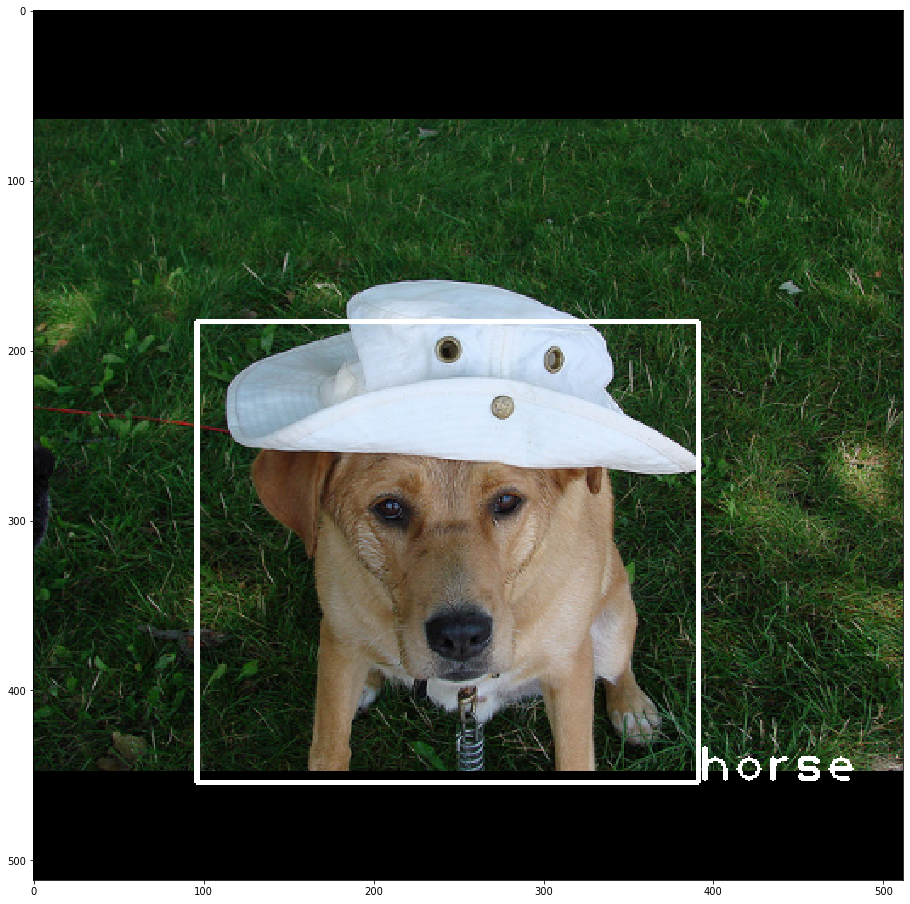

In [63]:
idx = 3

batch_images = batch_data[idx]['image']

batch_images = batch_data[idx]['image']
batch_base_loc = batch_data[idx]['base_loc']
batch_images.shape

cls_pred, loc_pred = model.predict(batch_images)

### Below cell Equivalent to  predict_box 

# equi of __init__
# num_classes = 10 + 1
bg_index = num_classes - 1




loc_base = batch_base_loc
cls_pred = tf.convert_to_tensor(cls_pred)
loc_pred = tf.convert_to_tensor(loc_pred)

input_width = WIDTH
input_height = HEIGHT
top_n = 300
score_threshold = 0.05
std = 0.2
mean = 0


anchor_w_h = tf.tile(loc_base[:, :, 2:], [1, 1, 2]) - tf.tile(loc_base[:, :, :2], [1, 1, 2])
anchorbox = loc_base
loc_pred_abs = tf.map_fn(lambda x: (x[0] * std + mean) * x[1] + x[2],
                             elems=(loc_pred, anchor_w_h, anchorbox),
                             dtype=tf.float32,
                             back_prop=False)
x1 = tf.clip_by_value(loc_pred_abs[:, :, 0], 0, input_width)
y1 = tf.clip_by_value(loc_pred_abs[:, :, 1], 0, input_height)
x2 = tf.clip_by_value(loc_pred_abs[:, :, 2], 0, input_width)
y2 = tf.clip_by_value(loc_pred_abs[:, :, 3], 0, input_height)
loc_pred_abs = tf.stack([x1, y1, x2, y2], axis=2)

num_batch, num_anchor, _ = loc_pred_abs.shape
cls_best_score = tf.reduce_max(cls_pred, axis=-1)
cls_best_class = tf.argmax(cls_pred, axis=-1)

cls_best_score = tf.where(tf.not_equal(cls_best_class, bg_index), cls_best_score, 0)

# select top n anchor boxes to proceed
# Padded Nonmax suppression with threshold
selected_indices_padded = tf.map_fn(
            lambda x: tf.image.non_max_suppression_padded(
                x[0], x[1], top_n, pad_to_max_output_size=True, score_threshold=score_threshold).selected_indices,
            (loc_pred_abs, cls_best_score),
            dtype=tf.int32,
            back_prop=False)

valid_outputs = tf.map_fn(
            lambda x: tf.image.non_max_suppression_padded(
                x[0], x[1], top_n, pad_to_max_output_size=True, score_threshold=score_threshold).valid_outputs,
            (loc_pred_abs, cls_best_score),
            dtype=tf.int32,
            back_prop=False)
# return loc_pred_abs, selected_indices_padded, valid_outputs


cls_pred = cls_pred.numpy()
loc_pred_abs = loc_pred_abs.numpy()


# cls_pred pertains to batch, whereas ele_cls_pred pertains to an element of a batch

batch_idx = np.random.randint(0,16)
elem_selected_indices = selected_indices_padded[batch_idx]
elem_valid_outputs = valid_outputs[batch_idx]
elem_cls_pred = cls_pred[batch_idx]
elem_loc_pred_abs = loc_pred_abs[batch_idx]

indices = elem_selected_indices[:elem_valid_outputs] # indices into anchor boxes
indices = indices.numpy()

predicted_cls = elem_cls_pred[indices] 
predicted_cls = np.argmax(predicted_cls,-1)
predicted_bbox = elem_loc_pred_abs[indices]

predicted_cls

im = batch_images[batch_idx]
im = im.numpy()

fig = plt.figure(figsize=(16,16))
for bbox_index in range(len(predicted_bbox)):
    
    x1,y1,x2,y2 = predicted_bbox[bbox_index]
    cls = predicted_cls[bbox_index]
    cls = index2cat[cls]
    print(cls)
    cv2.rectangle(im, (int(x1), int(y1)), (int(x2), int(y2)), (255, 255, 255), 2)
    cv2.putText(im, cls, (int(x2), int(y2)), font, 2, (255,255,255),2,cv2.LINE_AA, False)
#     cv2.putText(im, cls, (int(x1)+1, int(y1)-14), font, 1, (255,255,0),9, cv2.LINE_AA, False)
    
plt.imshow(im)

In [31]:
index2cat = {
 0: 'bicycle',
 1: 'car',
 2: 'motorcycle',
 3: 'bus',
 4: 'train',
 5: 'truck',
 6: 'boat',
 7: 'bird',
 8: 'cat',
 9: 'dog',
 10: 'horse',
 11: 'sheep'}

{0:2, 1:3, 2:4 ,3:6 ,4:7,5:8,6:9,7:16,8:17,9:18,10:19,11:20 }


In [86]:
path = '/home/ubuntu/fastestimator/apphub/image_detection/retinanet_coco'
fp = os.path.join(path, 'val2014_bbox_results.json')
fp1 = os.path.join(path, 'bbox_result.json')

with open(fp,'r') as f:
    data = json.load(f)

old_tfms =      {0:1, 1:2, 2:3, 3:5, 4:6, 5:7, 6:8, 7:14, 8:15, 9:16, 10:17, 11:18}
category_tfms = {0:2, 1:3, 2:4 ,3:6 ,4:7, 5:8, 6:9, 7:16, 8:17, 9:18, 10:19, 11:20 }
the_tfms =      {1:2, 2:3, 3:4, 5:6, 6:7, 7:8, 8:9, 14:16, 15:17, 16:18, 17:19, 18:20 }

for dict_elem in data:
    val = dict_elem['category_id']
    dict_elem['category_id'] = the_tfms[val]

with open(fp1, 'w') as f:
    json.dump(data, f)

val_new = pd.read_csv('/home/ubuntu/coco/val_new.csv')

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

annFile='/home/ubuntu/coco/annotations/instances_val2014.json'
coco=COCO(annFile)


df = pd.read_csv('/home/ubuntu/coco/val_new.csv')
val_imgIds = df['image_id'].values
val_imgIds = [ int(elem) for elem in val_imgIds]



coco_pred = coco.loadRes('/home/ubuntu/fastestimator/apphub/image_detection/retinanet_coco/bbox_result.json')
# run COCO evaluation
coco_eval = COCOeval(coco, coco_pred, 'bbox')
coco_eval.params.imgIds = val_imgIds
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()




loading annotations into memory...
Done (t=4.49s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.77s).
Accumulating evaluation results...
DONE (t=0.78s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets